# Как работать с colab

Чтобы начать работать на gpu нужно зайти в меню Runtime -> Change runtime type и выбрать GPU

Основным минусом colab является то, что в случае длительного разрыва соединения или просто бездействия машинка на которой запущен ноутбук останавливается и все промежуточные модели теряются. Так что если есть доступ к каким-нибудь машинам с GPU, то возможно удобнее запускаться на них.

In [ ]:
from typing import List

import os
import numpy as np
import tqdm.notebook as tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as opt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import torchaudio

from matplotlib import pyplot as plt
import IPython.display as ipd
from IPython.display import clear_output

In [ ]:
DEVICE = 'cuda:0'

In [ ]:
START_PATH = './'

In [ ]:
CLASSES = [
    'zero',
    'one',
    'two',
    'three',
    'four',
    'five',
    'six',
    'seven',
    'eight',
    'nine',
    'up',
    'down',
    'right',
    'left',
    'go',
    'stop',
    'yes',
    'no',
    'on',
    'off'
]

# Данные

В качестве тренировачных данных есть 2 сета:
- чистый сет с записями из google speech commands, чтобы можно было обучать на них модель голосовой активации
- сет с шумами, чтобы можно было пытаться ими аугментировать записи для тренировки модели голосовой активации или денойзера


Данные: https://drive.google.com/file/d/1gl8G83SA29IuVZ3wR1SFQTH-S1sLUTrA/view?usp=sharing. Их можно скачать на свой google disk и подключить к колабу.

In [ ]:
%cd '~/Загрузки/AIDive'
import sparse_image_warp_pytorch
import spec_augment_pytorch

/home/sirius/Загрузки/AIDive


In [ ]:
def add_noise(clean, noise, max_amp):
    noise_amp = np.random.rand() * max_amp
    max_start = noise.shape[1] - clean.shape[1]
    start = np.random.randint(0, max_start + 1)
    noise_part = noise[:, start:start+clean.shape[1]]
    noise_mult = clean.abs().max() / noise_part.abs().max() * noise_amp
    return (clean + noise_part * noise_mult) / (1 + noise_amp)

In [ ]:
class AudioDataset(Dataset):
    def __init__(
        self, audio_path, noise_path=None, in_memory=True,
        prepare_fun=torchaudio.transforms.MFCC(melkwargs={'n_mels': 80}),
        max_amp: float = 1.0
    ):
        """
        audio_path -- path to clean audio in train set or path to full test set
        noise_path -- path to noise audio, may be usefull for augmentations in train set
        in_memory -- load all feats into memory (faster but need more RAM)
        max_amp -- diff in max amplitudes in clean and noise data
        """
        super().__init__()
        self._prepare_fun = prepare_fun
        self._max_amp = max_amp
        if audio_path is None:
            assert noise_path is None
            return
        self._pathes, self._labels = self._path_traversall(audio_path)
        assert (
            all([label is None for label in self._labels]) or
            all([label is not None for label in self._labels])
        )
        self._noise = None
        if noise_path:
            self._noise, _ = self._path_traversall(noise_path)
        self._audio_data = None
        self._noise_data = None
        if in_memory:
            self._audio_data = [torchaudio.load(path) for path in self._pathes]
        # Здесь внизу не должно быть табулции? (Загрузка noise не должна быть в условином операторе на in_memory?)
        if self._noise:
            self._noise_data = [torchaudio.load(path) for path in self._noise]

    @classmethod
    def _create_from_loaded(
        cls, pathes, labels, noise, audio_data, noise_data, prepare_fun, max_amp
    ):
        obj = AudioDataset(None, prepare_fun=prepare_fun, max_amp=max_amp)
        obj._pathes = pathes
        obj._labels = labels
        obj._noise = noise
        obj._audio_data = audio_data
        obj._noise_data = noise_data
        return obj

    def _path_traversall(self, path, label=None):
        pathes = []
        labels = []
        for filename in os.listdir(path):
            if os.path.splitext(filename)[1] == '.wav':
                pathes.append(os.path.join(path, filename))
                if label is not None:
                    labels.append(CLASSES.index(label))
                else:
                    labels.append(None)
            elif os.path.isdir(os.path.join(path, filename)):
                assert label is None
                new_pathes, new_labels = self._path_traversall(
                    os.path.join(path, filename), label=filename
                )
                pathes.extend(new_pathes)
                labels.extend(new_labels)
            else:
                raise RuntimeError(f'Unknorwn file extension for {filename}')
        return pathes, labels

    def __len__(self):
        return len(self._pathes)

    def __getitem__(self, idx):
        assert 0 <= idx < len(self._pathes)
        audio = None
        if self._audio_data is not None:
            audio = self._audio_data[idx]
        else:
            audio = torchaudio.load(self._pathes[idx])
        audio, fs = audio
        assert fs == 16000
        feats = self._prepare_fun(audio)
        assert feats.shape[0] == 1
        return_dict = {
            'clean_feats': feats[0],
            'clean_audio': audio,
            'uttid': os.path.split(self._pathes[idx])[-1]
        }
        if self._noise is not None:
            random_noise_idx = np.random.randint(0, len(self._noise))
            noise_audio, fs = self._noise_data[random_noise_idx]
            assert fs == 16000
            assert noise_audio.shape[1] >= audio.shape[1]
            noise_audio = add_noise(audio, noise_audio, self._max_amp)
            return_dict['noise_audio'] = noise_audio
            assert torch.max(noise_audio) < 1
            feats = self._prepare_fun(noise_audio)
            assert feats.shape[0] == 1
            return_dict['noise_feats'] = feats[0]
        else:
            return_dict['noise_audio'] = return_dict['clean_audio']
            return_dict['noise_feats'] = return_dict['clean_feats']
        if self._labels[idx] is not None:
            return_dict['label'] = self._labels[idx]
        return_dict["prepare_fun"] = self._prepare_fun
        return return_dict

    def split(self, train_part=0.9, seed=42):
        np.random.seed(seed)
        train_pathes = []
        train_labels = []
        train_audio_data = None if self._audio_data is None else []
        val_pathes = []
        val_labels = []
        val_audio_data = None if self._audio_data is None else []
        for idx in range(len(self._pathes)):
            if np.random.rand() < train_part:
                train_pathes.append(self._pathes[idx])
                train_labels.append(self._labels[idx])
                if train_audio_data is not None:
                    train_audio_data.append(self._audio_data[idx])
            else:
                val_pathes.append(self._pathes[idx])
                val_labels.append(self._labels[idx])
                if val_audio_data is not None:
                    val_audio_datjua.append(self._audio_data[idx])
        return (
            AudioDataset._create_from_loaded(
                train_pathes, train_labels, self._noise, train_audio_data,
                self._noise_data, self._prepare_fun, self._max_amp
            ),
            AudioDataset._create_from_loaded(
                val_pathes, val_labels, self._noise, val_audio_data,
                self._noise_data, self._prepare_fun, self._max_amp
            )
        )
    
    def set_max_amp(self, max_amp: float):
        self._max_amp = max_amp

In [ ]:
fullcleanset = AudioDataset(os.path.join(START_PATH, 'speech_commands_train'), in_memory=False)
traincleanset, valcleanset = fullcleanset.split()
fullnoiseset = AudioDataset(
    os.path.join(START_PATH, 'speech_commands_train'),
    noise_path=os.path.join(START_PATH, 'noises'), in_memory=False
)
trainnoiseset, valnoiseset = fullnoiseset.split()
testset = AudioDataset(os.path.join(START_PATH, 'test_data'), in_memory=False)

## Как выглядят полученные данные

Вот например чистые аудиофайлы:

In [ ]:
ipd.display(ipd.Audio(fullnoiseset._noise_data[2][0].numpy(), rate=16000))

In [ ]:
random_idxes = np.random.randint(0, len(fullnoiseset), size=10)
for idx in random_idxes:
    ipd.display(ipd.Audio(fullnoiseset[idx]['clean_audio'], rate=8000))

А тут уже зашумлённые.

In [ ]:
for idx in random_idxes:
    ipd.display(ipd.Audio(fullnoiseset[idx]['noise_audio'], rate=16000))

## Отрисовка спектрограммы

In [ ]:
np.arange(0, len(fullnoiseset[random_idxes[7]]['clean_audio'][0]), 1.5).astype(int)[:10]

array([ 0,  1,  3,  4,  6,  7,  9, 10, 12, 13])

In [ ]:
ipd.display(ipd.Audio(fullnoiseset[random_idxes[7]]['clean_audio'][:, np.arange(0, len(fullnoiseset[random_idxes[7]]['clean_audio'][0]), 1.25).astype(int)], rate=16000))

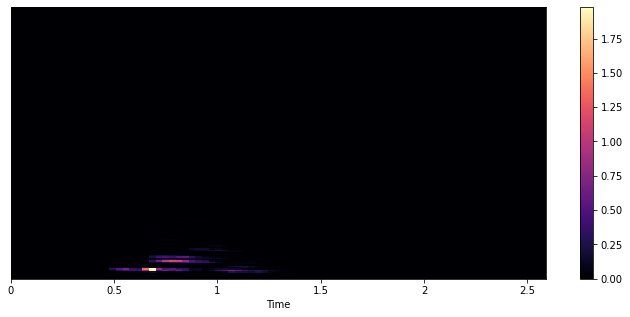

In [ ]:
import librosa
from librosa import display
sr=16000
mel_1 = torchaudio.transforms.Spectrogram()(fullnoiseset[random_idxes[7]]['clean_audio']).numpy()[0]
plt.figure(figsize=(12, 5))
librosa.display.specshow(
    mel_1, sr=sr, x_axis="time"
)
plt.colorbar()

/home/sirius/Загрузки/AIDive/sparse_image_warp_pytorch.py:180: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  X, LU = torch.solve(rhs, lhs)
/home/sirius/Загрузки/AIDive/sparse_image_warp_pytorch.py:375: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha = torch.tensor(queries - floor, dtype=grid_type)


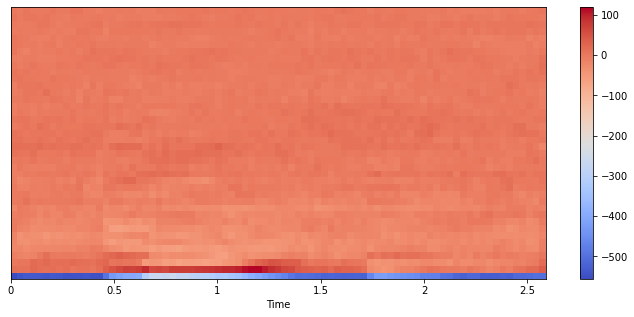

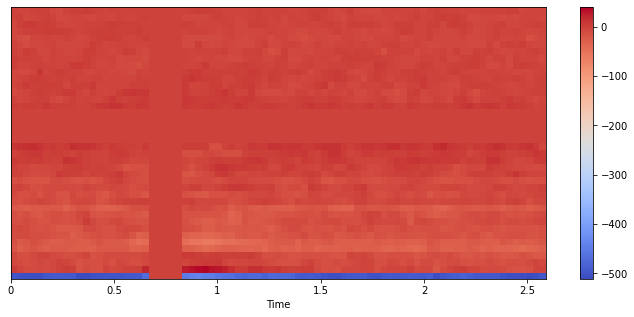

In [ ]:
import librosa
from librosa import display
sr=16000
mel_1 = torchaudio.transforms.MFCC(melkwargs={'n_mels': 80})(fullnoiseset[random_idxes[7]]['clean_audio']).numpy()[0]
plt.figure(figsize=(12,5))
librosa.display.specshow(
    mel_1, sr=sr, x_axis="time"
)
plt.colorbar()

mel_2 = spec_augment_pytorch.spec_augment(torch.tensor(fullnoiseset[random_idxes[0]]['noise_feats'].
                                               numpy().
                                               reshape((1, 40, -1))), 
                                  time_warping_para=5, 
                                  time_masking_para=9,
                                  frequency_masking_para=8).numpy()[0]
plt.figure(figsize=(12,5))
librosa.display.specshow(
    mel_2, sr=sr, x_axis="time"
)
plt.colorbar()

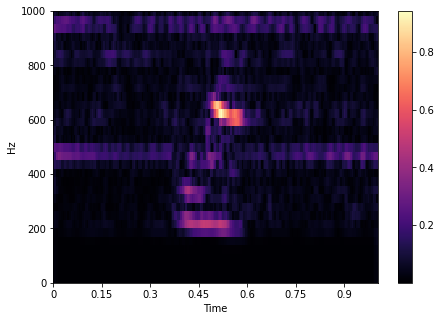

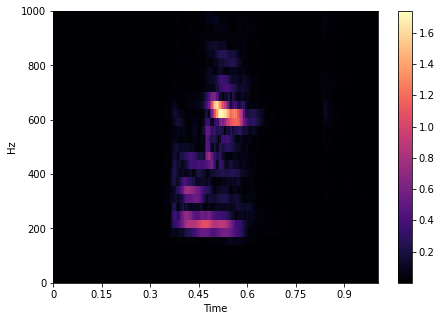

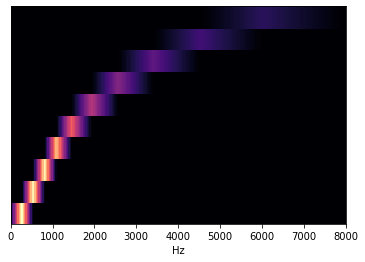

In [ ]:

hop_length = 80
n_fft = 512
sr = 16000

spectrogram1 = np.abs(librosa.stft(
    fullnoiseset[random_idxes[1]]['noise_audio'].numpy()[0], n_fft=n_fft, hop_length=hop_length
))

plt.figure(figsize=(16, 5))
plt.subplot(121)
librosa.display.specshow(
    spectrogram1, sr=sr, hop_length=hop_length,
    x_axis='time', y_axis='hz'
)
plt.ylim([0, 1000])
plt.colorbar()


spectrogram2 = np.abs(librosa.stft(
    fullnoiseset[random_idxes[1]]['clean_audio'].numpy()[0], n_fft=n_fft, hop_length=hop_length
))

plt.figure(figsize=(16, 5))
plt.subplot(122)
librosa.display.specshow(
    spectrogram2, sr=sr, hop_length=hop_length,
    x_axis='time', y_axis='hz'
)
plt.ylim([0, 1000])
plt.colorbar()
plt.show()

mel = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=10)

librosa.display.specshow(mel, sr=sr, hop_length=hop_length, 
                         x_axis='linear');

In [ ]:
# Проход по всем векторам аудио и вычисление средних минимального и максимального занчений 
clean_mean_min = 0
clean_mean_max = 0
for i in range(len(fullnoiseset._pathes)):
    audio, _ = torchaudio.load(fullnoiseset._pathes[i])
    clean_mean_min += audio.min()
    clean_mean_max += audio.max()
clean_mean_min /= len(fullnoiseset._pathes)
clean_mean_max /= len(fullnoiseset._pathes)
noise_mean_min = 0
noise_mean_max = 0
for i in range(len(fullnoiseset._noise_data)):
    noise_mean_min += fullnoiseset._noise_data[i][0].min()
    noise_mean_max += fullnoiseset._noise_data[i][0].max()
noise_mean_min /= len(fullnoiseset._noise_data)
noise_mean_max /= len(fullnoiseset._noise_data)
print('clean data mean scope equal to', clean_mean_min, clean_mean_max)
print('noise data mean scope equal to', noise_mean_min, noise_mean_max)

clean data mean scope equal to tensor(-0.0158) tensor(0.0157)
noise data mean scope equal to tensor(-0.0027) tensor(0.0027)


In [ ]:
MIN_LEN = 100
for i in tqdm.trange(len(fullcleanset)):
    MIN_LEN = min(fullcleanset[i]['clean_feats'].shape[1], MIN_LEN)
print('min len of audio equal to', MIN_LEN, 'frames')

  0%|          | 0/69708 [00:00<?, ?it/s]

min len of audio equal to 21 frames


In [ ]:
torchaudio.transforms.MFCC(melkwargs={"n_mels": 80}).forward(torchaudio.load(trainnoiseset._pathes[0])[0])[0]

tensor([[-5.6990e+02, -5.8961e+02, -5.7578e+02,  ..., -5.7089e+02,
         -5.8739e+02, -5.7893e+02],
        [ 5.5877e+00, -1.6383e+01, -7.8994e+00,  ..., -1.3395e+01,
         -1.6446e+01, -1.6969e+01],
        [ 2.1646e+01,  8.4440e+00,  6.3873e+00,  ...,  4.5678e+00,
          3.0573e+00,  6.1729e+00],
        ...,
        [-6.2296e+00, -3.1982e+00, -1.5085e-01,  ..., -3.0933e+00,
          7.0093e-02, -4.4298e+00],
        [ 1.8439e-01, -2.2665e+00, -2.6672e+00,  ..., -3.6192e+00,
          1.0480e-01, -3.1748e+00],
        [-1.6405e+00, -5.2240e-01,  3.7631e-01,  ..., -1.9329e+00,
         -7.0160e-01,  5.0929e+00]])

In [ ]:
MAX_LEN = 0
for i in tqdm.trange(len(fullcleanset)):
    MAX_LEN = max(fullcleanset[i]['clean_feats'].shape[1], MAX_LEN)
print('max len of audio equal to', MAX_LEN, 'frames')

  0%|          | 0/69708 [00:00<?, ?it/s]

max len of audio equal to 81 frames


In [ ]:
# join_in_batch сдвигает массив примерно на середину?
def join_in_batch(batch, key, key_audio="noise_audio"):
    X = torch.zeros((len(batch), batch[0][key].shape[0], MAX_LEN))
    for i in range(len(batch)):
#         print(batch[i][key])
#         print(batch[i]["prepare_fun"](torch.tensor(stretch(batch[i]["noise_audio"][0].numpy(), 0.75)).reshape((1, -1)).float())[0])
#         for j, signal in zip([0, 1, 2], 
#                              [batch[i][key],
#                               batch[i]["prepare_fun"](batch[i]['noise_audio'][:, np.arange(0, len(batch[i]['noise_audio'][0]), 1.5).astype(int)].reshape((1, -1)).float())[0],
#                               batch[i]["prepare_fun"](batch[i]['noise_audio'][:, np.arange(0, len(batch[i]['noise_audio'][0]), 1.25).astype(int)].reshape((1, -1)).float())[0]
#                               ]):
            signal = batch[i][key]
            j = 0
            diff = MAX_LEN - signal.shape[1]
            start = diff // 2
            end = MAX_LEN - diff + start
            X[i + j, :, start:end] = signal
    return X

def spotter_collate_fn(batch):
    """Need to join in batch utterances of different length"""
    X = join_in_batch(batch, 'noise_feats')
    if 'label' not in batch[0]:
        return X
#     Y = torch.tensor([item['label'] for item in batch for i in range(3)])
    Y = torch.tensor([item['label'] for item in batch ])
    return X, Y

In [ ]:
def denoiser_collate_fn(batch):
    """Need to join in batch utterances of different length"""
    X = join_in_batch(batch, 'noise_feats')
    Y = join_in_batch(batch, 'clean_feats')
    return X, Y

In [ ]:
def test_collate_fn(batch):
    """Need to join in batch utterances of different length"""
    X = join_in_batch(batch, 'noise_feats')
    Y = [item['uttid'] for item in batch]
    return X, Y

# Модель голосовой активации

Модель голосовой активации на входе принимает матрицу из признаков размера (время $\times$ количество признаков). Поверх этого можно запустить достаточно простую свёрточную модель с 1d свёртками, ибо считаем, что нам интересны локальные зависимости в пространстве времени, а пространство признаков становится чем-то вроде пространства каналов в случае картинок.

In [ ]:
def spotter_eval(model, val_data, batch_size=256):
    model.eval()
    val_loader = DataLoader(
        val_data, batch_size=batch_size, shuffle=True, num_workers=8,
        collate_fn=spotter_collate_fn
    )
    val_loss, val_acc, val_batches = 0, 0, 0
    for X, Y in tqdm.tqdm(val_loader):
        preds = model.forward(X.to(DEVICE))
        loss = F.cross_entropy(preds, Y.to(DEVICE))
        val_loss += loss.detach().cpu().data.numpy()
        val_acc += np.mean((torch.argmax(preds, dim=-1).cpu() == Y).data.numpy())
        val_batches += 1
    return val_loss / val_batches, val_acc / val_batches
    

def spotter_train(model, train_data, val_data, n_epochs=10, batch_size=256, noise_scheduler=tuple(), aug=True):
    optimizer = opt.Adam(model.parameters())
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
    train_loader = DataLoader(
        train_data, batch_size=batch_size, shuffle=True, num_workers=8,
        collate_fn=spotter_collate_fn
    )
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    for epoch in range(n_epochs):
        print(f"Эпоха {epoch + 1}/{n_epochs}")
        if noise_scheduler:
            idx = int(epoch / n_epochs * len(noise_scheduler))
            train_data.set_max_amp(noise_scheduler[idx])
        train_loss, train_acc, train_batches = 0, 0, 0
        model.train()
        for X, Y in tqdm.tqdm(train_loader):
            for i in range(len(X)):
                if aug and np.random.randint(0, 2):
                    X[i] = spec_augment_pytorch.spec_augment(X[i].reshape((1, 40, -1)), 
                                time_warping_para=5, 
                                time_masking_para=9,
                                frequency_masking_para=8)[0]
            preds = model.forward(X.to(DEVICE))
            loss = F.cross_entropy(preds, Y.to(DEVICE))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.cpu().data.numpy()
            train_acc += np.mean((torch.argmax(preds, dim=-1).cpu() == Y).data.numpy())
            train_batches += 1
        val_loss, val_acc = spotter_eval(model, val_data, batch_size=batch_size)
        scheduler.step(val_loss)
        train_losses.append(train_loss / train_batches)
        train_accs.append(train_acc / train_batches)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        clear_output(wait=True)
        print(f"Validation loss: {val_losses[-1]}\nValidation accuracy: {val_accs[-1]}")
        fig, axis = plt.subplots(1, 2, figsize=(15, 7))
        axis[0].plot(train_losses, label='train')
        axis[0].plot(val_losses, label='val')
        axis[1].plot(train_accs, label='train')
        axis[1].plot(val_accs, label='val')
        axis[0].set_xlabel('epoch')
        axis[1].set_xlabel('epoch')
        axis[0].set_ylabel('cross entropy loss')
        axis[1].set_ylabel('accuracy')
        axis[0].legend()
        axis[1].legend()
        plt.show()

In [ ]:
class Conv1dModule(nn.Module):
    def __init__(self, n_in, n_out, kernel, batchnorm=False, dropout_zero_prob=0.0, padding=False):
        super().__init__()
        pad = 0
        if padding:
          # Почему padding применим только для нечетных сверток?
            assert kernel % 2 == 1
            pad = kernel // 2
        modules = [nn.Conv1d(n_in, n_out, kernel, padding=pad)]
        if batchnorm:
            modules.append(nn.BatchNorm1d(n_out))
        modules.append(nn.ReLU())
        modules.append(nn.Dropout(p=dropout_zero_prob))
        self._net = nn.Sequential(*modules)

    def forward(self, X):
        return self._net.forward(X)


class Flatten(nn.Module):
    def forward(self, X):
        return X.reshape(X.shape[0], -1)


class FlattenModule(nn.Module):
    def __init__(self, n_in, n_out, batchnorm=False, dropout_zero_prob=0.0):
        super().__init__()
        modules = [nn.Linear(n_in, n_out)]
        if batchnorm:
            modules.append(nn.BatchNorm1d(n_out))
        modules.append(nn.ReLU())
        modules.append(nn.Dropout(p=dropout_zero_prob))
        self._net = nn.Sequential(*modules)

    def forward(self, X):
        return self._net.forward(X)


class Conv1dModel(nn.Module):
    def __init__(
        self, shapes: List[int], flatten_shapes: List[int], kernels: List[int],
        batchnorm=False, dropout_zero_prob=0.0
    ):
        """
        shapes -- List of size n_conv_layers + 1 with input shape for model and
            output shapes for each layer
        flatten_shapes -- List of size n_flatten_layers + 1 with input shape
            for first layer and output shape for each dense layer at the end of network
        kernels -- List of size n_conv_layers (kernel size of each model layer)
        batchnorm -- flag for use batchnorm or not
        dropout_zero_prob -- probabily of dropout zeroing after each conv1dBlock
        """
        super().__init__()
        assert len(kernels) + 1 == len(shapes)
        modules = []
        for i in range(len(kernels)):
            modules.append(Conv1dModule(
                shapes[i], shapes[i + 1], kernels[i], batchnorm=batchnorm,
                dropout_zero_prob=dropout_zero_prob
            ))
        modules.append(Flatten())
        for i in range(len(flatten_shapes) - 2):
            modules.append(FlattenModule(
                flatten_shapes[i], flatten_shapes[i + 1], batchnorm=batchnorm,
                dropout_zero_prob=dropout_zero_prob
            ))
        modules.append(nn.Linear(flatten_shapes[-2], flatten_shapes[-1]))
        self._net = nn.Sequential(*modules)

    def forward(self, X):
        return self._net.forward(X)

In [ ]:
conv1d_clean_model = Conv1dModel(
    [40, 64, 128, 256, 512, 256, 128, 64],
    [64 * (81 - 4 * 3 - 2 * 4), 1024, 256, 20],
        # 64 -- is number of channels, 81 -- max len at start,
        # 4 * 2 + 2 * 3 -- size of lost eges by conv1d operations
    [3, 3, 3, 3, 5, 5, 5]
).to(DEVICE)
spotter_train(conv1d_clean_model, traincleanset, valcleanset, n_epochs=50)

In [ ]:
spotter_eval(conv1d_clean_model, valcleanset)

In [ ]:
spotter_eval(conv1d_clean_model, valnoiseset)

  0%|          | 0/27 [00:00<?, ?it/s]

(1.5958398359793204, 0.5191343514421501)

## Тренировка на грязных данных

In [ ]:
conv1d_noise_model = Conv1dModel(
    [40, 64, 128, 256, 512, 256, 128, 64],
    [64 * (81 - 4 * 3 - 2 * 4), 1024, 256, 20],
        # 64 -- is number of channels, 81 -- max len at start,
        # 4 * 2 + 2 * 3 -- size of lost eges by conv1d operations
    [3, 3, 3, 3, 5, 5, 5]
).to(DEVICE)
spotter_train(conv1d_noise_model, trainnoiseset, valnoiseset, n_epochs=70)

In [ ]:
spotter_eval(conv1d_noise_model, valnoiseset)

  0%|          | 0/27 [00:00<?, ?it/s]

(0.6609278497872529, 0.7927126864142904)

Попробуем увеличивать степень шума постепенно:

Validation loss: 0.37787795397970414
Validation accuracy: 0.8748681272533595


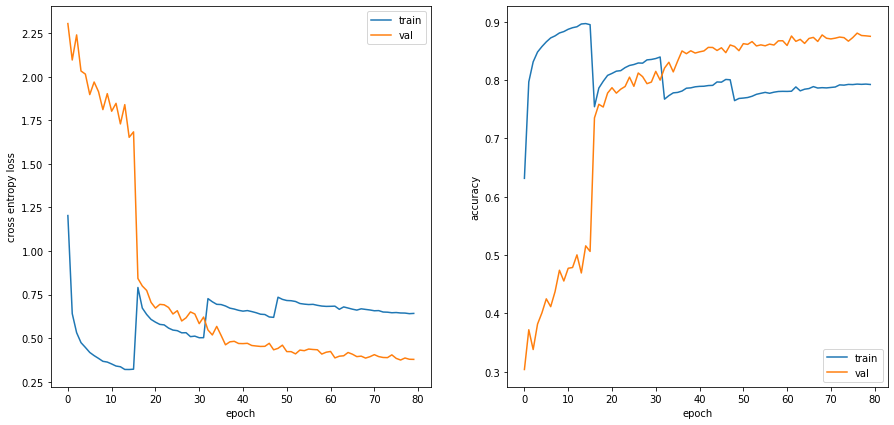

In [ ]:
conv1d_noise_model = Conv1dModel(
    [40, 64, 128, 256, 512, 256, 128, 64],
    [64 * (81 - 4 * 3 - 2 * 4), 1024, 256, 20],
        # 64 -- is number of channels, 81 -- max len at start,
        # 4 * 2 + 2 * 3 -- size of lost eges by conv1d operations
    [3, 3, 3, 3, 5, 5, 5],
    batchnorm=True,
    dropout_zero_prob=0.1
).to(DEVICE)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)
spotter_train(conv1d_noise_model, trainnoiseset, valnoiseset, n_epochs=80,  noise_scheduler=(0.0, 0.4, 0.8, 1.0, 1.0))

In [ ]:
spotter_eval(conv1d_noise_model, valnoiseset)

# Попробуем добавить денойзер

In [ ]:
def denoiser_train(model, train_data, val_data, n_epochs=10, batch_size=256, noise_scheduler=tuple()):
    optimizer = opt.Adam(model.parameters())
    train_loader = DataLoader(
        train_data, batch_size=batch_size, shuffle=True, num_workers=4,
        collate_fn=denoiser_collate_fn
    )
    val_loader = DataLoader(
        val_data, batch_size=batch_size, shuffle=True, num_workers=4,
        collate_fn=denoiser_collate_fn
    )
    train_losses, val_losses = [], []
    for epoch in range(n_epochs):
        if noise_scheduler:
            idx = int(epoch / n_epochs * len(noise_scheduler))
            train_data.set_max_amp(noise_scheduler[idx])
        train_loss, train_batches = 0, 0
        model.train()
        for X, Y in tqdm.tqdm(train_loader):
            preds = model.forward(X.to(DEVICE))
            loss = F.mse_loss(preds, Y.to(DEVICE))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.cpu().data.numpy()
            train_batches += 1
        val_loss, val_batches = 0, 0
        model.eval()
        for X, Y in tqdm.tqdm(val_loader):
            preds = model.forward(X.to(DEVICE))
            loss = F.mse_loss(preds, Y.to(DEVICE))
            val_loss += loss.detach().cpu().data.numpy()
            val_batches += 1
        train_losses.append(train_loss / train_batches)
        val_losses.append(val_loss / val_batches)
        clear_output(wait=True)
        plt.plot(train_losses, label='train')
        plt.plot(val_losses, label='val')
        plt.xlabel('epoch')
        plt.ylabel('cross entropy loss')
        plt.legend()
        plt.show()

In [ ]:
class SimpleDenoiserModel(nn.Module):
    def __init__(self, shapes: List[int], kernels: List[int], batchnorm=False, dropout_zero_prob=0.0):
        super().__init__()
        assert len(shapes) == len(kernels) + 1
        modules = []
        for i in range(len(kernels) - 1):
            modules.append(Conv1dModule(
                shapes[i], shapes[i + 1], kernels[i], batchnorm=batchnorm,
                dropout_zero_prob=dropout_zero_prob if i + 1 < len(kernels) else 0.0,
                padding=True
            ))
        assert kernels[-1] % 2 == 1
        modules.append(nn.Conv1d(shapes[-2], shapes[-1], kernels[-1], padding=kernels[-1] // 2))
        self._net = nn.Sequential(*modules)

    def forward(self, X):
        return self._net.forward(X)

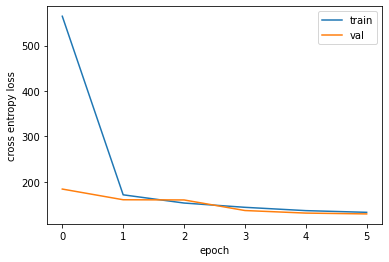

KeyboardInterrupt: ignored

In [ ]:
model = SimpleDenoiserModel([40, 64, 128, 64, 40], [3, 3, 3, 3]).to(DEVICE)
denoiser_train(model, trainnoiseset, valnoiseset, n_epochs=50)

In [ ]:
def eval_spotter_with_denoiser(denoiser, spotter, val_data, batch_size=256):
    denoiser.eval()
    spotter.eval()
    val_loader = DataLoader(
        val_data, batch_size=batch_size, shuffle=True, num_workers=8,
        collate_fn=spotter_collate_fn
    )
    val_loss, val_acc, val_batches = 0, 0, 0
    for X, Y in tqdm.tqdm(val_loader):
        clean = denoiser.forward(X.to(DEVICE))
        preds = spotter.forward(clean)
        loss = F.cross_entropy(preds, Y.to(DEVICE))
        val_loss += loss.detach().cpu().data.numpy()
        val_acc += np.mean((torch.argmax(preds, dim=-1).cpu() == Y).data.numpy())
        val_batches += 1
    return val_loss / val_batches, val_acc / val_batches

In [ ]:
eval_spotter_with_denoiser(model, conv1d_clean_model, valnoiseset)

  0%|          | 0/30 [00:00<?, ?it/s]

(3.1197474718093874, 0.5897056899078728)

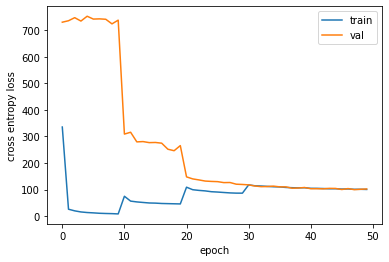

In [ ]:
model = SimpleDenoiserModel([40, 64, 128, 64, 40], [3, 3, 3, 3]).to(DEVICE)
denoiser_train(model, trainnoiseset, valnoiseset, n_epochs=50, noise_scheduler=(0.0, 0.1, 0.5, 1.0, 1.0))

In [ ]:
eval_spotter_with_denoiser(model, conv1d_clean_model, valnoiseset)

  0%|          | 0/30 [00:00<?, ?it/s]

(3.3650543610254924, 0.5627335898241206)

# Отправка решения

Перед завершением контеста нужно переотправить последнее решение, ибо будет учитываться только последняя посылка

In [ ]:
def final_eval(
    spotter, test_data, denoiser=None,
    save_path=os.path.join(START_PATH, 'results2.tsv'), batch_size=256
):
    spotter.eval()
    if denoiser:
        denoiser.eval()
    test_loader = DataLoader(
        test_data, batch_size=batch_size, shuffle=True, num_workers=2,
        collate_fn=test_collate_fn
    )
    val_loss, val_acc, val_batches = 0, 0, 0
    results = []
    for X, Y in tqdm.tqdm(test_loader):
        X = X.to(DEVICE)
        if denoiser:
            X = denoiser.forward(X)
        preds = spotter.forward(X)
        classes = torch.argmax(preds, dim=-1).cpu().data.numpy()
        labels = [CLASSES[idx] for idx in classes]
        results.extend([uttid, label] for uttid, label in zip(Y, labels))
    with open(save_path, 'w') as fout:
        for uttid, label in results:
            fout.write(f'{uttid}\t{label}\n')

In [ ]:
final_eval(conv1d_noise_model, testset)

  0%|          | 0/303 [00:00<?, ?it/s]

# Что можно попробовать

## Улучшение архитектуры

- [ ] использовать svdf слои
- [ ] использовать lstm слои
- [ ] использовать self-attention слои
- [ ] использовать более глубокие модели, тогда может пригодиться добавлание skip-connection и батч-нормализация.
- [ ] использовать аугментации, так как сет достаточно маленький, то они должны помочь (https://arxiv.org/abs/1904.08779)

## Улучшение тренировки

- [ ] использовать шедулеры для уменьшения lr: можно руками прописать расписание или использовать cosine-annealing scheduler
- [ ] обучить сразу денойзер, а потом споттер (в отличии от того, что было в бейзлайне)
- [ ] обучать споттер и денойзер одновременно, например объеденив их в одну модель, где сразу идёт денойзер, затем споттер, причём для выходов денойзера и споттера есть свои разные лосы.
- [ ] кроме того можно попробовать денойзер работающий не на признаках, а на сыром аудио (https://arxiv.org/pdf/2006.12847.pdf)

## Перебор

Наверняка параметры текущей архитектуры не оптимальные, так что можно перебрать например:

- [ ] используемые признаки
- [ ] глубину сетей
- [ ] ширину сетей
- [ ] использование/нет батчнормализацию
- [ ] нормализацию аудио на входе. Например можно посчитать статистики призакнов в трейнсете и нормализовать все записи на данные статистики
- [ ] значение дропаута